In [40]:
import sys
sys.path.append('..')
import theano.tensor as T
import theano
import numpy
import theano_lstm
import numpy as np
import data_managers
import os
import cPickle

# Plotting
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
net = theano_lstm.lstm_rnn( 300, [(128,128)], 150, save_weights_every=50000)

//anaconda/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


In [3]:
%%time
net.initialize_training_adam()

CPU times: user 2min 33s, sys: 2.31 s, total: 2min 35s
Wall time: 2min 38s


In [21]:
reload(data_managers)
data_butler = data_managers.character_data_manager('/Users/alex/Desktop/data manager/',
                                                   batch_size=1,perms_per=5,minmax_doc_length=[0,300])
data_butler.convert_ent_to_one_hot()

Now offering: Training data!


In [43]:
with open( data_butler.load_path + 'entity_vectors.pkl', 'rb' ) as f:
    ent_vecs = cPickle.load(f)
with open( data_butler.load_path + 'bad_entity_vectors.pkl', 'rb' ) as f:
    bEnt_vecs = cPickle.load(f)

In [44]:
data_butler.ent_vecs = ent_vecs
data_butler.bEnt_vecs = bEnt_vecs

In [22]:
def smooth_rep(data,sigma):
    w = np.ceil(2*sigma)
    f = np.exp( -.5*(np.arange(-w,w)**2)/(sigma**2) )
    f = f / np.sum(f)

    y = np.convolve(data,f,'valid')
    x = np.arange(w,len(data)-w+1)
    return x, y

In [31]:
# Re-initialize the network
net.initialize_network_weights(scale_down=0.6, b_f_offset=0.75)

# Initialize cost 
cost = []

data_butler.set_batch_size(1)
data_butler.set_perms_per(5)

Batch Size = 1;  Stride = 1
5 examples per offer: Batch Size = 1  *  Permutations per = 5


KeyboardInterrupt: 

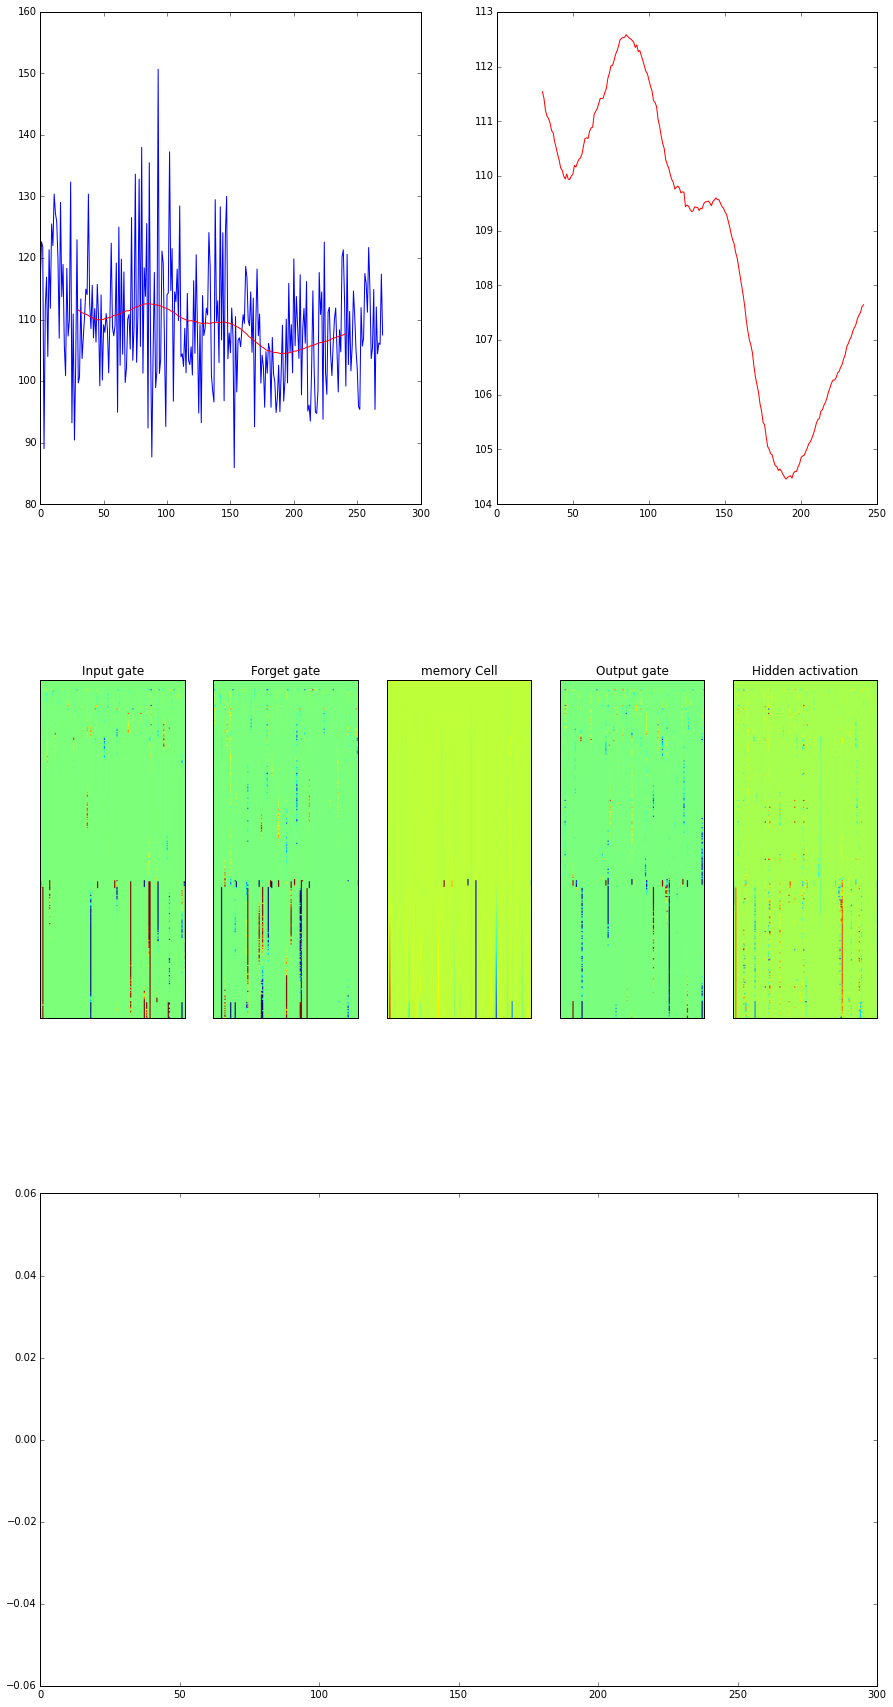

In [68]:
n_batches = 1000

start_plot_at = 0
smooth_sigma = 15

#Create plot 
fig = plt.figure(figsize=(15,30))
axB = fig.add_subplot(321)
axS = fig.add_subplot(322)
fig.subplots_adjust(wspace=.2)

labels = ['Input gate','Forget gate','memory Cell','Output gate','Hidden activation']
ax_list = []
for sp in range(len(labels)):
    ax_list.append(fig.add_subplot(3,len(labels),(1*len(labels))+sp+1))

axD = fig.add_subplot(3,1,3)

for batch in range(n_batches):
    
    # Get the permuted data
    vectors, lengths, answer = data_butler.offer_data()
    
    # Step 
    temp_cost,_ = net.adam_step(vectors, lengths, answer)
    cost.append(temp_cost)
    
    # Update plot
    if len(cost) > start_plot_at:
        C = 100.* np.array(cost[start_plot_at:]) / .04004
    else:
        C = 100.* cost / .04004
    x, y = smooth_rep( C, smooth_sigma )
    axB.cla();
    axS.cla();
    if len(x) == len(y):
        axB.plot( np.arange(start_plot_at,len(cost)), C, 'b', x+start_plot_at, y, 'r')
        axS.plot( x+start_plot_at, y, 'r')
    else:
        axB.plot( np.arange(start_plot_at,len(cost)), C, 'b' )

    hidden_players = net.hidden_activations(vectors[:,:,:2])
    for ax,gtp,title in zip(ax_list, hidden_players, labels):
        ax.imshow(gtp[:lengths[1],:,1]-gtp[:lengths[0],:,0])
        ax.set_title(title)
        ax.set_yticks([])
        ax.set_xticks([])

    axD.cla();
    axD.plot( np.mean(np.abs(hidden_players[4][:lengths[1],:,1]-hidden_players[4][:lengths[0],:,0]),axis=1) );
    axD.set_xlim([0,lengths[0]]);
    
    display.clear_output(wait=True)
    display.display(fig)

In [69]:
cost

[array(0.0463719298070875),
 array(0.0491018312607845),
 array(0.04877064400416619),
 array(0.035637904924081976),
 array(0.04488563701804902),
 array(0.04679986740483651),
 array(0.04164163122542816),
 array(0.048581499688648916),
 array(0.04477364051923233),
 array(0.050263280187468375),
 array(0.048851793758127),
 array(0.052208825128092884),
 array(0.05094695622901694),
 array(0.05041929741963038),
 array(0.047994683031720435),
 array(0.04282922257315548),
 array(0.05166148864943726),
 array(0.045532039434105685),
 array(0.04762913039847368),
 array(0.042373795066191),
 array(0.04038878943190301),
 array(0.04737410477499453),
 array(0.04296769730712344),
 array(0.04402223118861564),
 array(0.05298999423827162),
 array(0.0373256751464832),
 array(0.04440404283955065),
 array(0.03620462580876492),
 array(0.04127183608758319),
 array(0.04923497262257191),
 array(0.03991664146243533),
 array(0.040307794094360784),
 array(0.04538722900870348),
 array(0.04150324048778178),
 array(0.04291

In [72]:
with open(data_butler.load_path + 'query_list.pkl','rb') as f:
    Q = cPickle.load(f)

In [73]:
len(Q)

86432

In [46]:
len(cost)

941

In [48]:
#cost_one_hot = cost

In [58]:
y = T.matrix(dtype=theano.config.floatX)
targets = T.matrix('targets', dtype=theano.config.floatX)

# Through the LSTM stack, then soft max
p = net.soft_reader.process(y)

# Cost is based on the probability given to each entity
cost_sym = T.mean(T.nnet.binary_crossentropy(p, targets))

tmp_fun = theano.function([y,targets],[p, cost_sym])

In [62]:
answer[:,0:1].shape

(150, 1)

In [65]:
fake_y = np.zeros((128,3))
fake_targ = answer[:,0:3]

tmp_fun( fake_y, fake_targ )

[array([[ 0.00666667,  0.00666667,  0.00666667],
        [ 0.00666667,  0.00666667,  0.00666667],
        [ 0.00666667,  0.00666667,  0.00666667],
        [ 0.00666667,  0.00666667,  0.00666667],
        [ 0.00666667,  0.00666667,  0.00666667],
        [ 0.00666667,  0.00666667,  0.00666667],
        [ 0.00666667,  0.00666667,  0.00666667],
        [ 0.00666667,  0.00666667,  0.00666667],
        [ 0.00666667,  0.00666667,  0.00666667],
        [ 0.00666667,  0.00666667,  0.00666667],
        [ 0.00666667,  0.00666667,  0.00666667],
        [ 0.00666667,  0.00666667,  0.00666667],
        [ 0.00666667,  0.00666667,  0.00666667],
        [ 0.00666667,  0.00666667,  0.00666667],
        [ 0.00666667,  0.00666667,  0.00666667],
        [ 0.00666667,  0.00666667,  0.00666667],
        [ 0.00666667,  0.00666667,  0.00666667],
        [ 0.00666667,  0.00666667,  0.00666667],
        [ 0.00666667,  0.00666667,  0.00666667],
        [ 0.00666667,  0.00666667,  0.00666667],
        [ 0.00666667